In [34]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    SpatialPadd,
    RandRotate90d,
    CenterSpatialCropd,
    ResizeWithPadOrCropd,
    Flipd,
    Rotate90d,
    RandAffined,
    RandGaussianNoised,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    pad_list_data_collate,
    SmartCacheDataset
)

import numpy as np
import torch

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = "./run"
model = UNETR(
    in_channels=1,
    out_channels=5,
    img_size=(96, 96, 16),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)
# pre_dict = torch.load(r"F:\sth\23Fall\fcpro\code\run\best_metric_model59.pth")
# new_pre = {}
# for k,v in pre_dict.items():
#     name = k[7:]
#     new_pre[name] = v
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model67v2.pth")))
# model.load_state_dict(new_pre)
# model.load_state_dict("F:\sth\23Fall\fcpro\code\run\best_metric_model59.pth")


<All keys matched successfully>

In [36]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-50,
            a_max=100,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        Rotate90d(keys=["image"], k=1)
        # ResizeWithPadOrCropd(keys=["image"], spatial_size=(512, 512, 16)),
    ]
)

In [37]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Spacingd(keys=["image", "label"], pixdim=(2.0, 2.0, 0.1), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-50,
            a_max=100,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        # CropForegroundd(keys=["image", "label"], source_key="image"),
        # Resize(spatial_size=(400, 400, 12)),
        ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(512, 512, 16)),
        Rotate90d(keys=["image", "label"], k=1),
        # CenterSpatialCropd(keys=['image', 'label'], roi_size=(352,352,16)),
        # Flipd(keys=["image", "label"], spatial_axis=[0]),
    ]
)

In [38]:
test_file = [{'image':r'F:\sth\23Fall\fcpro\brain_image_copy\image\60020599.nii.gz'}]
test_ins = SmartCacheDataset(data=test_file, transform=test_transforms)[0]
test_image = test_ins['image']
print(test_image.shape)


Loading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]

torch.Size([1, 512, 512, 17])


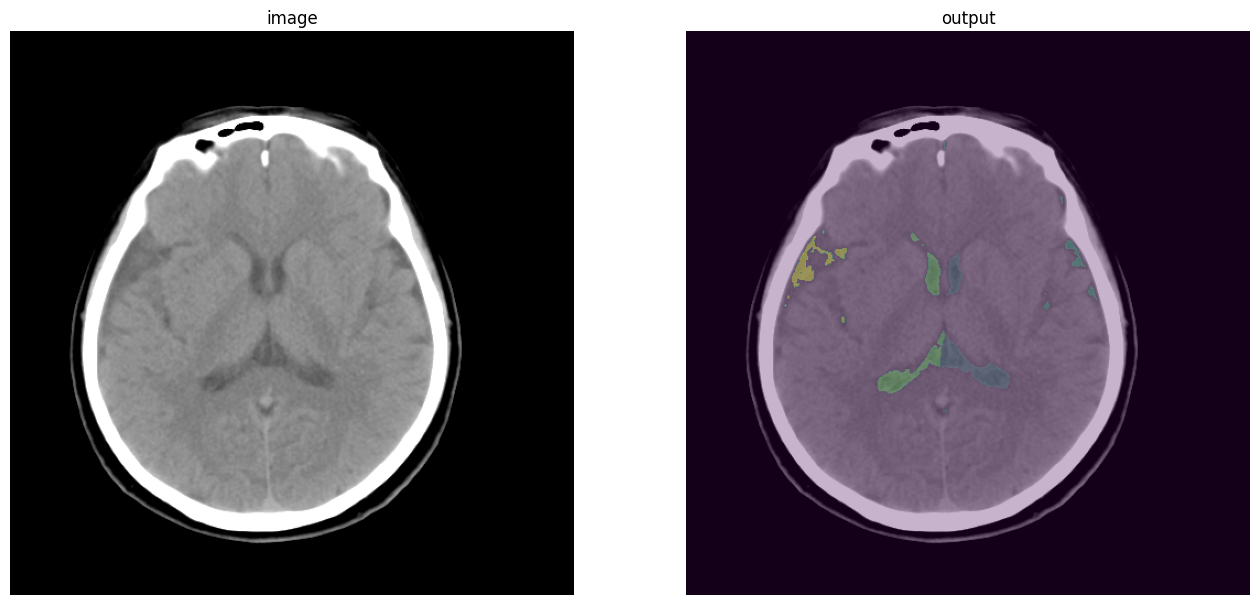

In [39]:
slice = 8

with torch.no_grad():

    inputs = torch.unsqueeze(test_image, 1).cuda()

    val_outputs = sliding_window_inference(inputs, (96, 96, 16), 8, model, overlap=0.8)
    plt.figure("check", (16, 10))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.axis('off') # 去掉坐标
    plt.imshow(inputs.cpu().numpy()[0, 0, :, :, slice], cmap="gray")
    

    plt.subplot(1, 2, 2)
    plt.title("output")
    plt.axis('off') # 去掉坐标
    plt.imshow(inputs.cpu().numpy()[0, 0, :, :, slice], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice], alpha=0.3)
    plt.show()

# Validation

In [40]:
data_dir = r"F:\sth\23Fall\fcpro\brain_image2"
split_json = "./dataset.json"

datasets = data_dir + split_json

val_files = load_decathlon_datalist(datasets, True, "validation")

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=0)

Loading dataset:   0%|          | 0/6 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 6/6 [00:00<00:00,  7.61it/s]


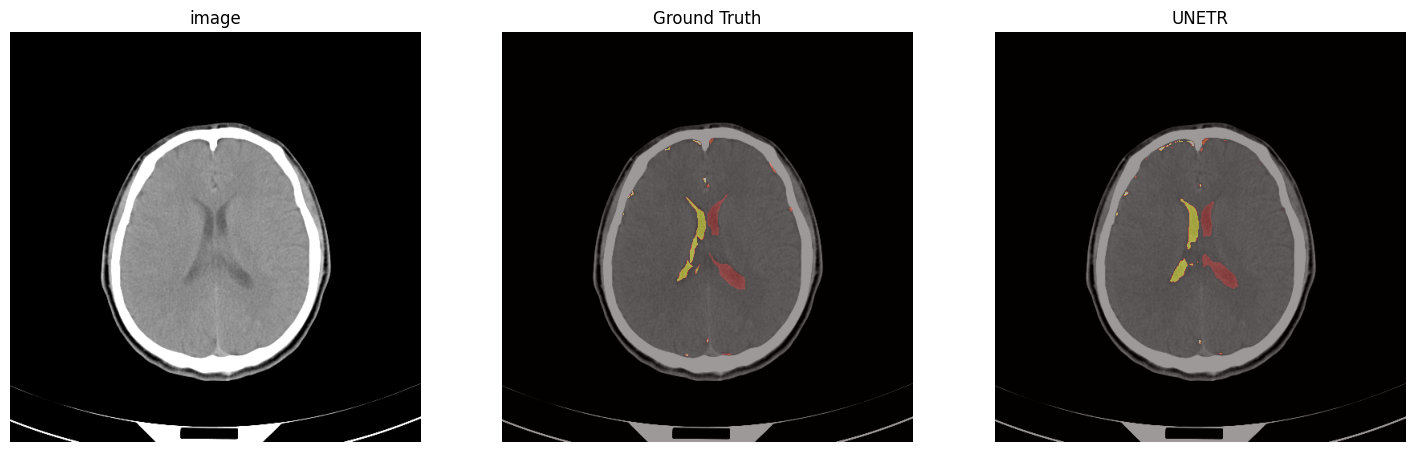

In [121]:
slice_map = {
    "brain_312_0000.nii.gz": 8,
    "brain_313_0000.nii.gz": 7,
    "brain_314_0000.nii.gz": 8,
    "brain_315_0000.nii.gz": 8,
    "brain_316_0000.nii.gz": 8,
    "brain_317_0000.nii.gz": 8,
    "brain_318_0000.nii.gz": 8,
    "brain_319_0000.nii.gz": 8,
    "brain_320_0000.nii.gz": 8,
    "brain_321_0000.nii.gz": 8,
    "brain_322_0000.nii.gz": 9,
    "brain_323_0000.nii.gz": 13,
    "brain_324_0000.nii.gz": 10,
    "brain_325_0000.nii.gz": 4,
    "brain_326_0000.nii.gz": 5,
    "brain_327_0000.nii.gz": 7,
    "brain_328_0000.nii.gz": 10,
    "brain_329_0000.nii.gz": 10,
    "brain_330_0000.nii.gz": 6,
    "brain_331_0000.nii.gz": 9,
    "brain_332_0000.nii.gz": 9,
    "brain_333_0000.nii.gz": 8,

}
case_num = 21
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model67v2.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()

    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 16), 8, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.axis('off') # 去掉坐标
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.axis('off') # 去掉坐标
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]], alpha=0.4, cmap="hot")
    plt.subplot(1, 3, 3)
    plt.title("UNETR")
    plt.axis('off') # 去掉坐标
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")

    out_image = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]]

    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]], alpha=0.4, cmap="hot")
    plt.axis('off') # 去掉坐标
    plt.show()

In [42]:
# 将mask与原图叠加
# plt.figure("check", (16, 10))
# plt.subplot(1, 2, 1)
# plt.title("image")
# plt.axis('off') # 去掉坐标
# plt.imshow(inputs.cpu().numpy()[0, 0, :, :, slice], cmap="gray")
# plt.subplot(1, 2, 2)
# plt.title("output")
# plt.axis('off') # 去掉坐标
# plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice])
# plt.show()



In [43]:
# import numpy as np
# import nibabel as nib

# val_outputs = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, :]
# val_outputs = val_outputs.numpy().astype('int16')
# # val_outputs = np.transpose(val_outputs, (2, 1, 0))
# val_outputs = np.rot90(val_outputs, k=3)
# val_outputs = nib.Nifti1Image(val_outputs, np.eye(4))
# nib.save(val_outputs, 'seg.nii.gz')